In [3]:
# default is to maximize the objectives
import time as time
import numpy as np
import copy
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math
from scipy.stats import norm

# example of a gaussian process surrogate function
from math import sin
from math import pi
from numpy import arange
from numpy import asarray
from numpy.random import normal
from numpy.random import uniform
from numpy.random import random
from warnings import catch_warnings
from warnings import simplefilter
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from autooed.utils.sampling import lhs
import random
#import xgboost as xgb
#from xgboost import XGBRegressor
#from xgboost import plot_tree
from sklearn import linear_model
from sklearn import ensemble

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
# import pydo
# generate random integer values
from random import seed
from random import randint
# seed random number generator
seed(1)
# Machine learning & model visualization tools
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.tree import export_graphviz
from sklearn import svm
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from numpy import cov
from scipy.stats import pearsonr
from scipy import ndimage, misc
#import pydot
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_absolute_error
# from sklearn.externals import joblib
# Miscellaneous
import os
import io
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense
#from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.inspection import partial_dependence, plot_partial_dependence
# Doing some chemistry and feature engineering of the structure
import pickle
import re
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from chainer_chemistry.datasets.molnet import get_molnet_dataset
# the package is in the same directory
from autooed.utils.sampling import lhs

import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
# get Today's date from python!
from datetime import datetime

In [4]:
## define RF_feature_gen:
##     input: R1, R2, ..,R6 ratios of the monomers
##     output: features as inputs of Black box RF 
## generate inputs to RF from ratios of monomers times the features
def RF_feature_gen(x):
    features = {
     'MolWt': Descriptors.MolWt,
     'HeavyAtomCount': Descriptors.HeavyAtomCount,
     'HeavyAtomMolWt': Descriptors.HeavyAtomMolWt,
     'NumHAcceptors': Descriptors.NumHAcceptors,
     'NumHDonors': Descriptors.NumHDonors,
     'NumHeteroatoms': Descriptors.NumHeteroatoms,
     'NumRotatableBonds': Descriptors.NumRotatableBonds,
     'NumValenceElectrons': Descriptors.NumValenceElectrons,
     'NumAromaticRings': Descriptors.NumAromaticRings,
     'NumSaturatedRings': Descriptors.NumSaturatedRings,
     'NumAliphaticRings': Descriptors.NumAliphaticRings,
     'NumRadicalElectrons': Descriptors.NumRadicalElectrons,
     'NumAliphaticCarbocycles': Descriptors.NumAliphaticCarbocycles,
     'NumAliphaticHeterocycles': Descriptors.NumAliphaticHeterocycles,
     'NumAromaticCarbocycles': Descriptors.NumAromaticCarbocycles,
     'NumAromaticHeterocycles': Descriptors.NumAromaticHeterocycles,
     'NumSaturatedCarbocycles': Descriptors.NumSaturatedCarbocycles,
     'NumSaturatedHeterocycles': Descriptors.NumSaturatedHeterocycles}
    # Modified Urethane Di-acrilate
    Oligoers_smiles = []
    RD_features = {}
    for f in features.keys():
        f = f + '_RD'
        RD_features[f] = []
        RD_SMILES = ['C=CC(=O)OCC(COC1=CC=CC=C1)O', 
                     'CC(C)CCCCCOC(=O)C=C', 
                     'C=CN1CCCC1=O',
                     'C=CC(=O)O', 
                     'C=CC(=O)NCCO',
                     'CC1(C2CCC1(C(C2)OC(=O)C=C)C)C']
    for i, smiles in enumerate(RD_SMILES):

        if (i + 1) % 5000 == 0:
            print('Currently processed: {}/{}'.format(i+1, len(SMILES)))

        m = AllChem.MolFromSmiles(smiles)

        for k, v in features.items():
            k = k + '_RD'
            try:
                 RD_features[k].append(v(m))
            except:
                 print ("the feature is not available for {}".format(smiles))


    RD_features = pd.DataFrame(RD_features)
    #print (RD_features.shape)
    X = np.array(x).reshape(-1,1)
    X_features = X * RD_features
    return X_features
#RD_features.to_csv('RD_features.csv', index = False)

In [124]:

df = pd.read_csv('Yuchao_20220511.csv')
#df = pd.read_csv('Imaginery_initial_.csv')
Tensile_Strength_Mpa = np.asarray (df['Tensile_Strength']).reshape(1,-1)
Toughness = np.asarray (df['Toughness']).reshape(1,-1)
Y = np.concatenate((Tensile_Strength_Mpa.T, Toughness.T),axis=1)

#X_ = df.to_numpy()
A_Ratio = np.asarray (df['R1(HA)']).reshape(1,-1)
B_Ratio = np.asarray (df['R2(IA)']).reshape(1,-1)
C_Ratio = np.asarray (df['R3(NVP)']).reshape(1,-1)
D_Ratio = np.asarray (df['R4(AA)']).reshape(1,-1)
E_Ratio = np.asarray (df['R5(HEAA)']).reshape(1,-1)
F_Ratio = np.asarray (df['R6(IBOA)']).reshape(1,-1)
X_ = np.concatenate((A_Ratio.T, B_Ratio.T, C_Ratio.T, D_Ratio.T, E_Ratio.T, F_Ratio.T), 
                    axis=1)

X_train, X_test, y_train, y_test = train_test_split(
   X_, Y, test_size=0.2)


regrRF = RandomForestRegressor(max_depth=5, random_state=9)
regrRF.fit(X_train, y_train)

r2_scoreRF_train = r2_score (y_train, regrRF.predict(X_train))
print ("r2_scoreRF_train", r2_scoreRF_train)

r2_scoreRF_test = r2_score (y_test, regrRF.predict(X_test))
print ("r2_scoreRF", r2_scoreRF_test)

r2_scoreRF_train 0.8905235629078323
r2_scoreRF 0.2833953958312443


In [13]:
Y

array([['Y'],
       ['Y'],
       ['Y'],
       ['Y'],
       ['Y'],
       ['Y'],
       ['Y'],
       ['Y'],
       ['Y'],
       ['Y'],
       ['Y'],
       ['Y'],
       ['Y'],
       ['Y'],
       ['Y'],
       ['Y'],
       ['Y'],
       ['Y'],
       ['Y'],
       ['Y'],
       ['Y'],
       ['Y'],
       ['Y'],
       ['Y'],
       ['Y'],
       ['Y'],
       ['N'],
       ['Y'],
       ['N'],
       ['N'],
       ['N'],
       ['N'],
       ['Y'],
       ['N'],
       ['Y'],
       ['Y'],
       ['N'],
       ['Y'],
       ['Y'],
       ['Y']], dtype=object)

In [138]:
# printability as Y
df = pd.read_csv('Yuchao_20220511.csv')
#df = pd.read_csv('Imaginery_initial_.csv')
Printability = np.asarray (df['Printability']).reshape(1,-1)
Y0 = Printability.T
Y = np.where(Y0 == 'Y', 1, 0)

#X_ = df.to_numpy()
A_Ratio = np.asarray (df['R1(HA)']).reshape(1,-1)
B_Ratio = np.asarray (df['R2(IA)']).reshape(1,-1)
C_Ratio = np.asarray (df['R3(NVP)']).reshape(1,-1)
D_Ratio = np.asarray (df['R4(AA)']).reshape(1,-1)
E_Ratio = np.asarray (df['R5(HEAA)']).reshape(1,-1)
#F_Ratio = np.asarray (df['R6(IBOA)']).reshape(1,-1)
X_ = np.concatenate((A_Ratio.T, B_Ratio.T, C_Ratio.T, D_Ratio.T, E_Ratio.T), 
                    axis=1)

X_train, X_test, y_train, y_test = train_test_split(
   X_, Y, test_size=0.2)


RF = RandomForestClassifier(max_depth=10)
RF.fit(X_train, y_train)
pred = RF.predict_proba(X_train)

print (RF.score(X_train, y_train))
print (RF.score(X_test, y_test))

1.0
1.0


<ipython-input-138-b9e38099779f>:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF.fit(X_train, y_train)


In [102]:
X_test

array([[0.  , 0.1 , 0.3 , 0.2 , 0.2 ],
       [0.  , 0.3 , 0.7 , 0.  , 0.  ],
       [0.15, 0.34, 0.07, 0.15, 0.1 ],
       [0.13, 0.05, 0.18, 0.05, 0.21],
       [0.12, 0.25, 0.23, 0.22, 0.15],
       [0.06, 0.17, 0.27, 0.11, 0.27],
       [0.2 , 0.  , 0.8 , 0.  , 0.  ],
       [0.29, 0.11, 0.19, 0.27, 0.07]])

In [114]:
RF.predict_proba([[0.3  , 0.6 , 0 , 0.1 , 0 ]])

array([[0.53, 0.47]])

In [96]:
Y2.shape

(40, 1)

In [97]:
Y.shape

(40, 1)

(20, 1)
Dim. of Search Space = 6
no metrics are going to be saved


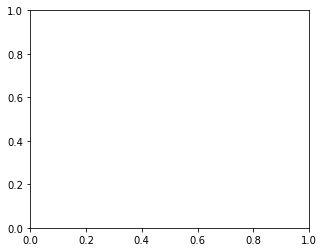

In [4]:
## Objective function 
def objective(x):
    Tensile_Strength_Mpa = float (input (
            "ratios A-F {} sum {} Enter Tensile Str. [Mpa]: ".
             format(np.round(x,2), np.sum(np.round(x,2)))))
    Toughness = float (input ("Enter Toughness in Mpa: "))
    objectives = np.array((Tensile_Strength_Mpa, Toughness))
    return objectives

def classifier(y):
    printability = input ("Enter the class: ")
    printability = int(printability)
    return printability
    #return 1 if np.all(abs(y) < 0.8) else 0
    
## define bounds for x, input variable, shape (NParam, 2) --> 2[lb, ub]
bounds = np.array([(0,1), (0,1), (0,1), (0,1), (0,1), (0,1)])
NObj = 2

random.seed(10)
np.random.seed(2021)
no_inputs = 6
dataset_size = 30

# reading data file
df = pd.read_csv('Yuchao_20220504.csv')

Tensile_Strength_Mpa = np.asarray (df['Tensile_Strength']).reshape(1,-1)
Toughness = np.asarray (df['Toughness']).reshape(1,-1)
Y = np.concatenate((Tensile_Strength_Mpa.T, Toughness.T),axis=1)

#X_ = df.to_numpy()
A_Ratio = np.asarray (df['R1(HA)']).reshape(1,-1)
B_Ratio = np.asarray (df['R2(IA)']).reshape(1,-1)
C_Ratio = np.asarray (df['R3(NVP)']).reshape(1,-1)
D_Ratio = np.asarray (df['R4(AA)']).reshape(1,-1)
E_Ratio = np.asarray (df['R5(HEAA)']).reshape(1,-1)
F_Ratio = np.asarray (df['R6(IBOA)']).reshape(1,-1)
X = np.concatenate((A_Ratio.T, B_Ratio.T, C_Ratio.T, D_Ratio.T, E_Ratio.T, F_Ratio.T), 
                    axis=1)

const = pd.Series(np.where(df.Printability.values == 'Y', 1, 0), df.index)
const = np.array(const).reshape(-1,1)
print (const.shape)
#RFMod = RandomForestClassifier().fit(X, const)

"""
def __init__(self, target, NObj, pbounds, constraints=[],
                 verbose=False, Picture=False, TPF=None,
                 n_restarts_optimizer=10, Filename=None,
                 MetricsPS=True, max_or_min='max', RandomSeed=None,
                 kernel=None)
"""

# constraints: list of dictionary [{'type': 'ineq', 'fun': constr_fun}, ...], 
# only inequality constraints are implemented. 
# constr_fun: 
counter = 0
def constr_fun(X):
    #start = time.time()
    #print (X[0:1])
    #print (type(X))
    xx = []
    for x in X:
        #print (x)
        xx.append(x)
    xx = np.array((xx)).reshape(1,-1)
    #print (xx)
    #print ("next")
    #print (RFMod.predict(xx))
    if self.RFMod.predict(xx)==0:
        g = -1
        #print ("g: ", g)
    else:
        g = 1
        #print ("g: ", g)
    #print ("g", g)
    #stop = time.time()
    #duration = stop - start
    #print('time for each iteration of constraint', duration)
    return g
# I redefined RF as constraints inside the iterations
constraints =  [{'type': 'ineq', 'fun': constr_fun}]


# if you minize!!! make sure: max_or_min='min' in mo.MOBayesianOpt
Optimizer = mo.MOBayesianOpt(target=objective, classifier=classifier, RF_feature_gen = RF_feature_gen, 
                             max_or_min='max', constraints=constraints, NObj=NObj, MetricsPS=True,
                             pbounds=bounds, verbose = True, Picture=True)
                             #Filename="MOBOpt.dat")

## initialize probes obj. functions the first random initial points
## init_points specifies how many random points
#Optimizer.initialize(init_points=50)
#plt.show()

In [5]:
# initialize(init_points=None, Points=None, Y=None)
Optimizer.initialize(Points=X, Y=Y, classes = const)
# if your initial data is ready
#Optimizer.initialize(Points=X, Y=Y)

Added points in init
   X0       X1       X2       X3       X4       X5     |    F0       F1       Class   
+1.5e-01 +2.0e-01 +2.0e-02 +2.1e-01 +1.8e-01 +2.4e-01  | +4.6e+01 +2.3e+00  | +1.0e+00 
+2.5e-01 +3.1e-01 +1.1e-01 +2.0e-02 +1.6e-01 +1.5e-01  | +1.8e+01 +1.2e+01  | +1.0e+00 
+6.0e-02 +1.7e-01 +2.7e-01 +1.1e-01 +2.7e-01 +1.2e-01  | +3.3e+01 +6.9e-01  | +1.0e+00 
+0.0e+00 +1.0e-01 +3.0e-01 +2.0e-01 +2.0e-01 +2.0e-01  | +2.8e+01 +7.0e-01  | +1.0e+00 
+3.5e-01 +3.5e-01 +0.0e+00 +0.0e+00 +1.0e-01 +2.0e-01  | +1.2e+00 +2.1e+00  | +1.0e+00 
+1.5e-01 +3.4e-01 +7.0e-02 +1.5e-01 +1.0e-01 +1.9e-01  | +2.9e+01 +2.2e+01  | +1.0e+00 
+1.3e-01 +8.0e-02 +1.6e-01 +3.6e-01 +2.0e-02 +2.5e-01  | +2.1e+01 +3.2e-01  | +1.0e+00 
+1.4e-01 +8.0e-02 +3.0e-02 +2.6e-01 +2.5e-01 +2.4e-01  | +2.7e+01 +1.1e+00  | +1.0e+00 
+0.0e+00 +0.0e+00 +5.0e-01 +0.0e+00 +3.0e-01 +2.0e-01  | +3.5e+01 +6.4e-01  | +1.0e+00 
+0.0e+00 +5.0e-02 +0.0e+00 +2.5e-01 +2.0e-01 +5.0e-01  | +2.2e+01 +4.0e-01  | +1.0e+00 
+1.0e-01 +0.

Start optimization loop
0  of  1


/home/kianoosh/github/ML_Composite_Fibers/_bayes.py:393: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.RFMod.fit(x_features, self.space.f_classifier)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


after NSGAII
pop:  [Individual('d', [0.20865082845426275, 0.30159494766510564, 0.10884851109166677, 0.12007474760353007, 0.10608048042178135, 0.15458043685106843]), Individual('d', [0.1282389317387247, 0.2579781109252965, 0.023050828487666257, 0.18192642424459962, 0.1802234115410084, 0.2290865359344364]), Individual('d', [0.1282389317387247, 0.2579781109252965, 0.023050828487666257, 0.18192642424459962, 0.1802234115410084, 0.2290865359344364]), Individual('d', [0.1486346958084319, 0.30552733719119085, 0.06698474373210692, 0.15227068793878176, 0.14071836288572317, 0.1851857437821079]), Individual('d', [0.1490991762550618, 0.306305684257781, 0.03985882088962485, 0.18192353761416302, 0.1400254153452609, 0.18372586152971218]), Individual('d', [0.1474525652574476, 0.2568312746222104, 0.06952649870463061, 0.18192232863451618, 0.14060631040140412, 0.20278775704252255]), Individual('d', [0.14862289433267376, 0.2876075974313184, 0.038860006218911586, 0.18190714312958642, 0.13970224520851748, 0.

ratios A-F [0.15 0.29 0.04 0.18 0.14 0.2 ] sum 1.0 Enter Tensile Str. [Mpa]: 50
Enter Toughness in Mpa: 10
Enter the class: 1
|PF| =    2 at    1 of    1, w/ r = 0.10
time duration:  214.65530681610107


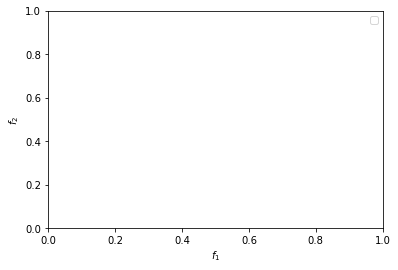

In [6]:
NIter = 1

# front = np.array of shape (nPts, NObj) --> Pareto Front (obj space)
# pop = np.array of shape (nPts, NParam) --> Pareto Set (search space)
"""
# see default values for the function
maximize(self,
                 n_iter=100,
                 prob=0.1,
                 ReduceProb=False,
                 q=0.5,
                 n_pts=100,
                 SaveInterval=10,
                 FrontSampling=[10, 25, 50, 100])
"""
# return front and pop from surrogate and all Evaluated samples [X][y], accordingly
front, pop, eval_y, eval_x = Optimizer.maximize(n_iter=NIter, n_pts=100, prob=0.1)


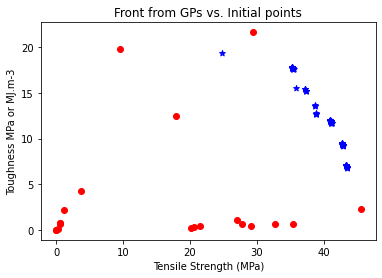

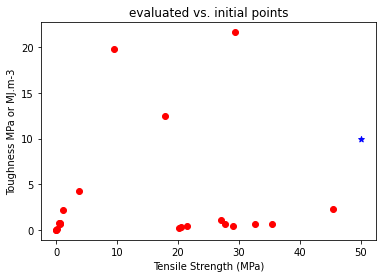

In [36]:
# Front calculated from GPs. vs. initial samples
plt.scatter(-front[:,0], -front[:,1], color='blue', marker = '*')
plt.scatter(Y[:,0], Y[:,1], color='red')
plt.xlabel('Tensile Strength (MPa)')
plt.ylabel('Toughness MPa or MJ.m-3')
plt.title ('Front from GPs vs. Initial points')
plt.savefig("GPsPF_evaluated.png", dpi=400)
plt.show()
#showing evaluated samples vs. initial training
# remove the training samples from Evaluated matrices
num_initial = X.shape [0]
plt.scatter(eval_y[num_initial:,0], eval_y[num_initial:,1], marker = "*", color='blue')
plt.scatter(Y[:,0], Y[:,1], color='red')
plt.title('evaluated vs. initial points')
plt.xlabel('Tensile Strength (MPa)')
plt.ylabel('Toughness MJ.m-3')
plt.savefig("evaluated_init.png", dpi=400)
plt.show()

In [37]:
X

array([[0.15, 0.2 , 0.02, 0.21, 0.18, 0.24],
       [0.25, 0.31, 0.11, 0.02, 0.16, 0.15],
       [0.06, 0.17, 0.27, 0.11, 0.27, 0.12],
       [0.  , 0.1 , 0.3 , 0.2 , 0.2 , 0.2 ],
       [0.35, 0.35, 0.  , 0.  , 0.1 , 0.2 ],
       [0.15, 0.34, 0.07, 0.15, 0.1 , 0.19],
       [0.13, 0.08, 0.16, 0.36, 0.02, 0.25],
       [0.14, 0.08, 0.03, 0.26, 0.25, 0.24],
       [0.  , 0.  , 0.5 , 0.  , 0.3 , 0.2 ],
       [0.  , 0.05, 0.  , 0.25, 0.2 , 0.5 ],
       [0.1 , 0.  , 0.25, 0.25, 0.25, 0.15],
       [0.12, 0.25, 0.23, 0.22, 0.15, 0.03],
       [0.3 , 0.3 , 0.1 , 0.1 , 0.1 , 0.1 ],
       [0.1 , 0.8 , 0.  , 0.1 , 0.  , 0.  ],
       [0.8 , 0.1 , 0.  , 0.1 , 0.  , 0.  ],
       [0.45, 0.45, 0.  , 0.  , 0.1 , 0.  ],
       [0.2 , 0.7 , 0.  , 0.  , 0.  , 0.1 ],
       [0.3 , 0.5 , 0.2 , 0.  , 0.  , 0.  ],
       [0.6 , 0.35, 0.05, 0.  , 0.  , 0.  ],
       [0.5 , 0.5 , 0.  , 0.  , 0.  , 0.  ]])

[0.57970074 0.23462096 0.12181334]
[1.30938464 0.83300714 0.60022315]


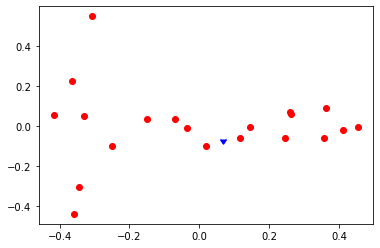

In [51]:
#PCA from Ratios 
pca = PCA(n_components=3, svd_solver='full')
pca.fit(X)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

pca_X = pca.transform(X)
pca_eval_x = pca.transform(eval_x[num_initial:,:])
plt.scatter(pca_X[:,0], pca_X[:,1], color='red')
plt.scatter(pca_eval_x[:,0], pca_eval_x[:,1], color='blue', marker=11)

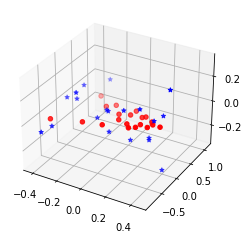

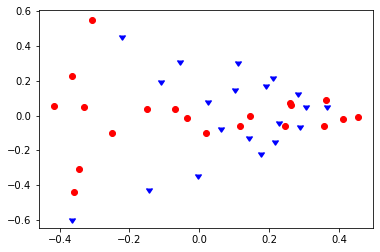

In [140]:
# PCA of Ratios of Training and Human decied samples before optimization starts 
df = pd.read_csv('Modified_Kia_20220505.csv')
#df = pd.read_csv('Imaginery_initial_.csv')
#X_ = df.to_numpy()
A_Ratio = np.asarray (df['R1(HA)']).reshape(1,-1)
B_Ratio = np.asarray (df['R2(IA)']).reshape(1,-1)
C_Ratio = np.asarray (df['R3(NVP)']).reshape(1,-1)
D_Ratio = np.asarray (df['R4(AA)']).reshape(1,-1)
E_Ratio = np.asarray (df['R5(HEAA)']).reshape(1,-1)
F_Ratio = np.asarray (df['R6(IBOA)']).reshape(1,-1)
X_future = np.concatenate((A_Ratio.T, B_Ratio.T, C_Ratio.T, D_Ratio.T, E_Ratio.T, F_Ratio.T), 
                    axis=1)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
pca_X_future = pca.transform(X_future)

ax.scatter(pca_X_future[:,0], pca_X_future[:,1], color='red')
            
ax.scatter(pca_X[:,0], 2*pca_X[:,1], pca_X[:,2], marker='*', color = 'blue')

plt.savefig("3d_PCAratios_Initial_Humandecided.png", dpi=400)
plt.show()

plt.scatter(pca_X[:,0], pca_X[:,1], color='red')

plt.scatter(pca_X_future[:,0], pca_X_future[:,1], color='blue', marker=11)
plt.show()

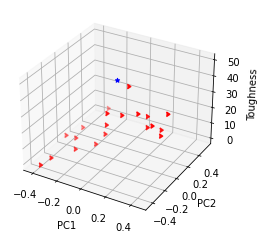

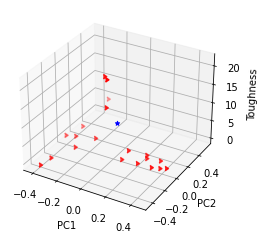

In [28]:
# 3D Scatter plot of x=PC1, y=PC2, z=Strength, PCA on Ratios
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(pca_eval_x[:,0], pca_eval_x[:,1], eval_y[num_initial:,0], marker='*', color = 'blue')
ax.scatter(pca_X[:,0], pca_X[:,1], Y[:,0], marker=5, color = 'red')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('Toughness')
plt.savefig("3d_PCAratios_Strength.png", dpi=400)
plt.show()

# 3D Scatter plot of x=PC1, y=PC2, z=Toughness, PCA on Ratios
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(pca_eval_x[:,0], pca_eval_x[:,1], eval_y[num_initial:,1], marker="*", color = 'blue')
ax.scatter(pca_X[:,0], pca_X[:,1], Y[:,1], marker=5, color = 'red')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('Toughness')
plt.savefig("3d_PCAratios_Toughness.png", dpi=400)
plt.show()

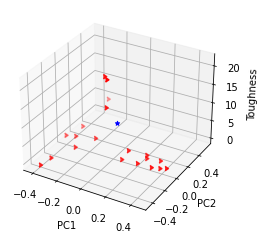

In [29]:
from mpl_toolkits import mplot3d

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter3D(pca_eval_x[:,0], pca_eval_x[:,1], eval_y[num_initial:,1], marker="*", color = 'blue')
ax.scatter3D(pca_X[:,0], pca_X[:,1], Y[:,1], marker=5, color = 'red')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('Toughness')
plt.savefig("3d_PCAratios_Toughness.png", dpi=400)
plt.show()

In [30]:
np.round(eval_x,2)

array([[0.15, 0.2 , 0.02, 0.21, 0.18, 0.24],
       [0.25, 0.31, 0.11, 0.02, 0.16, 0.15],
       [0.06, 0.17, 0.27, 0.11, 0.27, 0.12],
       [0.  , 0.1 , 0.3 , 0.2 , 0.2 , 0.2 ],
       [0.35, 0.35, 0.  , 0.  , 0.1 , 0.2 ],
       [0.15, 0.34, 0.07, 0.15, 0.1 , 0.19],
       [0.13, 0.08, 0.16, 0.36, 0.02, 0.25],
       [0.14, 0.08, 0.03, 0.26, 0.25, 0.24],
       [0.  , 0.  , 0.5 , 0.  , 0.3 , 0.2 ],
       [0.  , 0.05, 0.  , 0.25, 0.2 , 0.5 ],
       [0.1 , 0.  , 0.25, 0.25, 0.25, 0.15],
       [0.12, 0.25, 0.23, 0.22, 0.15, 0.03],
       [0.3 , 0.3 , 0.1 , 0.1 , 0.1 , 0.1 ],
       [0.1 , 0.8 , 0.  , 0.1 , 0.  , 0.  ],
       [0.8 , 0.1 , 0.  , 0.1 , 0.  , 0.  ],
       [0.45, 0.45, 0.  , 0.  , 0.1 , 0.  ],
       [0.2 , 0.7 , 0.  , 0.  , 0.  , 0.1 ],
       [0.3 , 0.5 , 0.2 , 0.  , 0.  , 0.  ],
       [0.6 , 0.35, 0.05, 0.  , 0.  , 0.  ],
       [0.5 , 0.5 , 0.  , 0.  , 0.  , 0.  ],
       [0.15, 0.29, 0.04, 0.18, 0.14, 0.2 ]])

In [31]:
eval_y

array([[45.51,  2.33],
       [17.95, 12.47],
       [32.74,  0.69],
       [27.81,  0.7 ],
       [ 1.2 ,  2.15],
       [29.43, 21.64],
       [20.54,  0.32],
       [27.03,  1.05],
       [35.42,  0.64],
       [21.52,  0.4 ],
       [20.23,  0.23],
       [29.07,  0.45],
       [ 9.55, 19.8 ],
       [ 0.  ,  0.  ],
       [ 3.67,  4.28],
       [ 0.57,  0.75],
       [ 0.  ,  0.  ],
       [ 0.53,  0.77],
       [ 0.59,  0.6 ],
       [ 0.2 ,  0.09],
       [50.  , 10.  ]])

### run the next chunk if you have real data evaluated

In [17]:
date = datetime.today().strftime('%Y%m%d')
eval_x_df = pd.DataFrame (np.round(eval_x, 2), columns = ['R1(HA)','R2(IA)','R3(NVP)',
                                             'R4(AA)','R5(HEAA)','R6(IBOA)'])
eval_x_df ['Tensile_Strength_Mpa'] = np.round(eval_y[:,0],1)
eval_x_df ['Toughness_MPa'] = np.round(eval_y[:,1],1)
eval_x_df.index += 1
#print (eval_x_df)
eval_x_df.to_csv(r'evaluated_{}.csv'.format(date))